In [1]:
# !pip install -U -q kaggle --force

In [2]:
# from google.colab import files
# f=files.upload()

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
# !mkdir -p ~/.kaggle

In [5]:
# !cp kaggle.json ~/.kaggle/

In [6]:
# !chmod 600 /root/.kaggle/kaggle.json

In [7]:
# !kaggle competitions download -c nnfl-lab-4

In [8]:
# %%bash
# cd /content
# unzip nnfl-lab-4.zip

In [9]:
import numpy as np 
import pandas as pd 
import os

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, Input, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import re

import codecs
import csv
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from keras.layers.merge import concatenate
from keras.layers import Dropout, Activation, Lambda
from keras.layers.normalization import BatchNormalization
from time import time
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## Training Data

In [10]:
train_df = pd.read_csv("train.csv", sep=",")

In [11]:
train_df.head()

,ID,Sentence1,Sentence2,Class
0,0,"But instead of returning to heaven , Annie dec...","But instead of returning to Heaven , Chris cho...",0
1,1,"In 2016 , Bacardi announced new branding and p...","In 2016 , Bacardi announced new branding and p...",0
2,2,Kweku Baako Jnr had four children . One of the...,"Baako had four children , one of whom was Kwek...",0
3,3,"As with the Navy , the Army has a single-track...","Like the army , the Navy has a single-track sy...",0
4,4,Sissi units have fewer crew served weapons and...,Sissi units have more weapons served by the cr...,0


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 4 columns):
ID           16000 non-null int64
Sentence1    16000 non-null object
Sentence2    16000 non-null object
Class        16000 non-null int64
dtypes: int64(2), object(2)
memory usage: 500.1+ KB


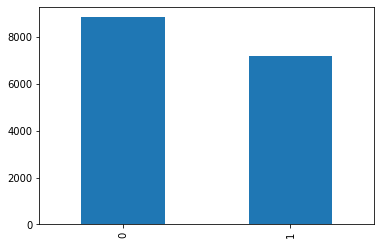

In [13]:
train_df['Class'].value_counts().plot.bar()

## Testing Data

In [14]:
test_df = pd.read_csv("test.csv", sep=",")
# submission_df = test_df['ID'].copy()
# submission_df.head()

In [15]:
test_df.head()

,ID,Sentence1,Sentence2
0,16000,How do I increase the rank on my website in SEO?,What are some tips on how to increase rank in ...
1,16001,I'm a boy. I masturbate. I'm 13. Is it bad to ...,Why do I masturbate when I'm stressed?
2,16002,The fourth season was premiered on 7 June 2010...,"The third season was premiered on June 7 , 201..."
3,16003,"In 2003 , he moved to London and lived there f...",He moved to South Africa in 2003 and lived the...
4,16004,Shawn told Shawn that his mother was not dead ...,Stefano told Shawn that his mother was not dea...


## Text to wordlist

In [16]:
import nltk
nltk.download('stopwords')
stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harnoor_dhingra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Prepare Embeddings

In [0]:
# EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin'

In [0]:
# !wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [0]:
# ! gunzip GoogleNews-vectors-negative300.bin.gz

In [0]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [0]:
# !unzip glove*.zip

In [17]:
embeddings_index = {}
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [18]:
vocabulary = dict()
inverse_vocabulary = ['<unk>']

sentence_cols = ['Sentence1', 'Sentence2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for sentence in sentence_cols:

            s2n = []  # q2n -> sentence numbers representation
            for word in text_to_word_list(row[sentence]):

                # Check for unwanted words
                if word in stops:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    s2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    s2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.at[index, sentence] = s2n

In [19]:
EMBEDDING_DIM = 300
embeddings = np.zeros((len(vocabulary) + 1, EMBEDDING_DIM))
for word, i in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embeddings[i] = embedding_vector

In [0]:
# vocabulary = dict()
# inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
# word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# sentence_cols = ['Sentence1', 'Sentence2']

# # Iterate over the questions only of both training and test datasets
# for dataset in [train_df, test_df]:
#     for index, row in dataset.iterrows():

#         # Iterate through the text of both questions of the row
#         for sentence in sentence_cols:

#             s2n = []  # q2n -> sentence numbers representation
#             for word in text_to_word_list(row[sentence]):

#                 # Check for unwanted words
#                 if word in stops and word not in word2vec.vocab:
#                     continue

#                 if word not in vocabulary:
#                     vocabulary[word] = len(inverse_vocabulary)
#                     s2n.append(len(inverse_vocabulary))
#                     inverse_vocabulary.append(word)
#                 else:
#                     s2n.append(vocabulary[word])

#             # Replace questions as word to question as number representation
#             dataset.at[index, sentence] = s2n
            
# embedding_dim = 300
# embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
# embeddings[0] = 0  # So that the padding will be ignored

# # Build the embedding matrix
# for word, index in vocabulary.items():
#     if word in word2vec.vocab:
#         embeddings[index] = word2vec.word_vec(word)

# del word2vec

## Prepare Training and Validation Sets

In [20]:
max_seq_length = max(train_df.Sentence1.map(lambda x: len(x)).max(),
                     train_df.Sentence2.map(lambda x: len(x)).max(),
                     test_df.Sentence1.map(lambda x: len(x)).max(),
                     test_df.Sentence2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 3200
training_size = len(train_df) - validation_size

X = train_df[sentence_cols]
Y = train_df['Class']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.Sentence1, 'right': X_train.Sentence2}
X_validation = {'left': X_validation.Sentence1, 'right': X_validation.Sentence2}
X_test = {'left': test_df.Sentence1, 'right': test_df.Sentence2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [21]:
for dataset, side in itertools.product([X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

assert X_test['left'].shape == X_test['right'].shape

## Model

In [22]:
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 32
n_epoch = 15

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), EMBEDDING_DIM, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = Bidirectional(LSTM(n_hidden))

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 12800 samples, validate on 3200 samples
Epoch 1/15
12800/12800 [==============================] - 167s 13ms/step - loss: 0.2446 - accuracy: 0.6652 - val_loss: 0.2246 - val_accuracy: 0.6809
Epoch 2/15
12800/12800 [==============================] - 166s 13ms/step - loss: 0.2099 - accuracy: 0.6876 - val_loss: 0.2121 - val_accuracy: 0.6853
Epoch 3/15
12800/12800 [==============================] - 165s 13ms/step - loss: 0.1935 - accuracy: 0.7077 - val_loss: 0.2073 - val_accuracy: 0.6903
Epoch 4/15
12800/12800 [==============================] - 165s 13ms/step - loss: 0.1830 - accuracy: 0.7257 - val_loss: 0.2035 - val_accuracy: 0.6966
Epoch 5/15
12800/12800 [==============================] - 164s 13ms/step - loss: 0.1750 - accuracy: 0.7434 - val_loss: 0.2006 - val_accuracy: 0.6997
Epoch 6/15
12800/12800 [==============================] - 163s 13ms/step - loss: 0.1679 - accuracy: 0.7579 - val_loss: 0.1984 - val_accuracy: 0.7072
Epoch 7/15
12800/12800 [==============================] -

In [ ]:
# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

In [0]:
# malstm.save_weights("model_try.h5")

In [ ]:
malstm.load_weights("2017A7PS0081G.h5")

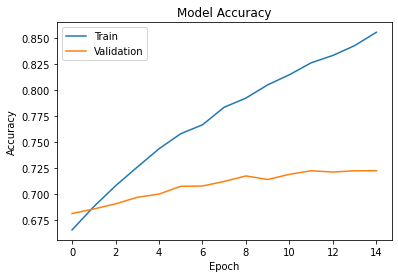

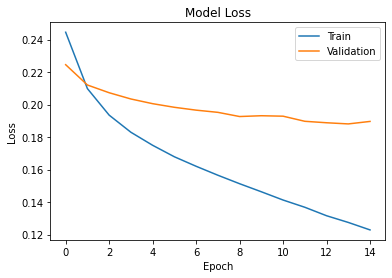

In [24]:
# Plot accuracy
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
pred = malstm.predict([X_test['left'], X_test['right']])
# pred = mlstm.predict()

# preds = model.predict([test_data_1, test_data_2])
# preds += model.predict([test_data_2, test_data_1])
# preds /= 2

In [0]:
test_ids = []
with codecs.open("../content/test.csv", encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        test_ids.append(values[0])

In [0]:
submission_df = pd.DataFrame({'ID':test_ids, 'Class':pred.ravel()})

In [28]:
submission_df.head()

,ID,Class
0,16000,0.109026
1,16001,0.127360
2,16002,0.452275
3,16003,0.124678
4,16004,0.235444


In [0]:
submission_df['Class'] = submission_df['Class'] > 0.5

In [0]:
submission_df['Class']=submission_df['Class'].astype('int')

In [31]:
submission_df.head()

,ID,Class
0,16000,0
1,16001,0
2,16002,0
3,16003,0
4,16004,0


In [0]:
submission_df.to_csv('submission_try.csv',index=False)

In [33]:
submission_df.head()

,ID,Class
0,16000,0
1,16001,0
2,16002,0
3,16003,0
4,16004,0


In [34]:
submission_df.head()

,ID,Class
0,16000,0
1,16001,0
2,16002,0
3,16003,0
4,16004,0


In [35]:
submission_df.head()

,ID,Class
0,16000,0
1,16001,0
2,16002,0
3,16003,0
4,16004,0


In [0]:
# submission_df.head()

In [36]:
submission_df.head()

,ID,Class
0,16000,0
1,16001,0
2,16002,0
3,16003,0
4,16004,0


In [0]:
# submission_df.head()

In [0]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):
    csv = submission_df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)
create_download_link(df)